In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [10]:
def modelfit(alg, feature_names, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    y_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(y_test)

    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(y_test, y_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp = feat_imp.rename(lambda x: feature_names[int(x[1:len(x)])])
    
    feat_imp.plot(kind='barh', title='Feature Importances',figsize=(7, 16))
    plt.ylabel('Feature Importance Score')

In [11]:
def ModelParamSearch(xgb, params, X_train, y_train):
    search = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print('\ngrid_scores')
    for score in search.grid_scores_:
        print(score)
    print('\nbest_params')
    print(search.best_params_)
    print('\nbest_score')
    print(search.best_score_)
    return search

In [64]:
X_train_df = pd.read_csv("../data/offline/X_train.csv", index_col=0)
y_train_df = pd.read_csv("../data/offline/y_train.csv", index_col=0)
X_test_df = pd.read_csv("../data/offline/X_test.csv", index_col=0)
combine_df = pd.concat([X_train_df, X_test_df])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df.values, y_train_df['SalePrice'].values, test_size=0.5, random_state=1729)

In [66]:
feature_names = X_train_df.columns

In [43]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,
                             silent=False, objective='reg:linear', subsample=0.8,
                             colsample_bytree=0.8, gamma=0, min_child_weight = 1,
                             scale_pos_weight=1, seed=27)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()


Model Report
RMSE : 0.02096


TypeError: 'str' object is not callable

In [44]:
xgb_model = xgb.XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 6,\
                             scale_pos_weight=1, seed=27)

params1 = {
 'max_depth':np.array(range(3,10,2)),
 'min_child_weight':np.array(range(1,6,2))
}
search = ModelParamSearch(xgb_model, params1, X_train, y_train)


grid_scores
mean: 0.88787, std: 0.02108, params: {'max_depth': 3, 'min_child_weight': 1}
mean: 0.89019, std: 0.02085, params: {'max_depth': 3, 'min_child_weight': 3}
mean: 0.89222, std: 0.01856, params: {'max_depth': 3, 'min_child_weight': 5}
mean: 0.88652, std: 0.02151, params: {'max_depth': 5, 'min_child_weight': 1}
mean: 0.88610, std: 0.02272, params: {'max_depth': 5, 'min_child_weight': 3}
mean: 0.89108, std: 0.01548, params: {'max_depth': 5, 'min_child_weight': 5}
mean: 0.88276, std: 0.01792, params: {'max_depth': 7, 'min_child_weight': 1}
mean: 0.88754, std: 0.02157, params: {'max_depth': 7, 'min_child_weight': 3}
mean: 0.89276, std: 0.01454, params: {'max_depth': 7, 'min_child_weight': 5}
mean: 0.88087, std: 0.01663, params: {'max_depth': 9, 'min_child_weight': 1}
mean: 0.88430, std: 0.01943, params: {'max_depth': 9, 'min_child_weight': 3}
mean: 0.88829, std: 0.01418, params: {'max_depth': 9, 'min_child_weight': 5}

best_params
{'max_depth': 7, 'min_child_weight': 5}

best_scor

In [45]:
params = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[4, 5, 6]
}
search2 = ModelParamSearch(xgb_model, params, X_train, y_train)

# 0.8959456941803028
# 0.8938496041827715


grid_scores
mean: 0.88760, std: 0.02346, params: {'max_depth': 4, 'min_child_weight': 4}
mean: 0.89163, std: 0.01634, params: {'max_depth': 4, 'min_child_weight': 5}
mean: 0.89161, std: 0.01689, params: {'max_depth': 4, 'min_child_weight': 6}
mean: 0.88890, std: 0.01657, params: {'max_depth': 5, 'min_child_weight': 4}
mean: 0.89108, std: 0.01548, params: {'max_depth': 5, 'min_child_weight': 5}
mean: 0.89024, std: 0.01906, params: {'max_depth': 5, 'min_child_weight': 6}
mean: 0.88942, std: 0.01962, params: {'max_depth': 6, 'min_child_weight': 4}
mean: 0.89170, std: 0.01611, params: {'max_depth': 6, 'min_child_weight': 5}
mean: 0.88978, std: 0.01540, params: {'max_depth': 6, 'min_child_weight': 6}

best_params
{'max_depth': 6, 'min_child_weight': 5}

best_score
0.8917041896777647


In [46]:
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}


search3 = ModelParamSearch(xgb_model, params3, X_train, y_train)

# best_params
# {'gamma': 0.0}

# best_score
# 0.8977214764046604


grid_scores
mean: 0.89170, std: 0.01611, params: {'gamma': 0.0}
mean: 0.88203, std: 0.01269, params: {'gamma': 0.1}
mean: 0.86763, std: 0.01793, params: {'gamma': 0.2}
mean: 0.85985, std: 0.02226, params: {'gamma': 0.3}
mean: 0.85512, std: 0.02497, params: {'gamma': 0.4}

best_params
{'gamma': 0.0}

best_score
0.8917041896777647


In [47]:
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)

param4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

search4 = ModelParamSearch(xgb_model, param4, X_train, y_train)

# best_params
# {'colsample_bytree': 0.7, 'subsample': 0.7}

# best_score
# 0.9001576485029655


grid_scores
mean: 0.89276, std: 0.01249, params: {'subsample': 0.6, 'colsample_bytree': 0.6}
mean: 0.89018, std: 0.01506, params: {'subsample': 0.7, 'colsample_bytree': 0.6}
mean: 0.88869, std: 0.01788, params: {'subsample': 0.8, 'colsample_bytree': 0.6}
mean: 0.88970, std: 0.01357, params: {'subsample': 0.9, 'colsample_bytree': 0.6}
mean: 0.89224, std: 0.01036, params: {'subsample': 0.6, 'colsample_bytree': 0.7}
mean: 0.88793, std: 0.01797, params: {'subsample': 0.7, 'colsample_bytree': 0.7}
mean: 0.89037, std: 0.01304, params: {'subsample': 0.8, 'colsample_bytree': 0.7}
mean: 0.88398, std: 0.01516, params: {'subsample': 0.9, 'colsample_bytree': 0.7}
mean: 0.89034, std: 0.01025, params: {'subsample': 0.6, 'colsample_bytree': 0.8}
mean: 0.89306, std: 0.01699, params: {'subsample': 0.7, 'colsample_bytree': 0.8}
mean: 0.89271, std: 0.01388, params: {'subsample': 0.8, 'colsample_bytree': 0.8}
mean: 0.89214, std: 0.01194, params: {'subsample': 0.9, 'colsample_bytree': 0.8}
mean: 0.88742, 

In [48]:
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

param5 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

search5 = ModelParamSearch(xgb_model, param5, X_train, y_train)


# best_params
# {'colsample_bytree': 0.65, 'subsample': 0.65}

# best_score
# 0.9007344923004951


grid_scores
mean: 0.89154, std: 0.01308, params: {'subsample': 0.65, 'colsample_bytree': 0.75}
mean: 0.89233, std: 0.01222, params: {'subsample': 0.7, 'colsample_bytree': 0.75}
mean: 0.89210, std: 0.01345, params: {'subsample': 0.75, 'colsample_bytree': 0.75}
mean: 0.89130, std: 0.01450, params: {'subsample': 0.65, 'colsample_bytree': 0.8}
mean: 0.89306, std: 0.01699, params: {'subsample': 0.7, 'colsample_bytree': 0.8}
mean: 0.88986, std: 0.01418, params: {'subsample': 0.75, 'colsample_bytree': 0.8}
mean: 0.89059, std: 0.01782, params: {'subsample': 0.65, 'colsample_bytree': 0.85}
mean: 0.89274, std: 0.01770, params: {'subsample': 0.7, 'colsample_bytree': 0.85}
mean: 0.88795, std: 0.01931, params: {'subsample': 0.75, 'colsample_bytree': 0.85}

best_params
{'subsample': 0.7, 'colsample_bytree': 0.8}

best_score
0.8930629974110973


In [52]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.7,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

param6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

search6 = ModelParamSearch(xgb_model, param6, X_train, y_train)


# best_params
# {'reg_alpha': 1}

# best_score
# 0.9008283650864461


grid_scores
mean: 0.89510, std: 0.01489, params: {'reg_alpha': 1e-05}
mean: 0.89287, std: 0.01629, params: {'reg_alpha': 0.01}
mean: 0.89130, std: 0.01527, params: {'reg_alpha': 0.1}
mean: 0.88054, std: 0.02006, params: {'reg_alpha': 1}
mean: -0.03454, std: 0.11018, params: {'reg_alpha': 100}

best_params
{'reg_alpha': 1e-05}

best_score
0.8950972092485718


In [53]:
param7 = {
 'reg_alpha':[1e-07, 1e-05, 1e-03]
}

search7 = ModelParamSearch(xgb_model, param7, X_train, y_train)


# best_params
# {'reg_alpha': 1.1}

# best_score
# 0.9009523929423489


grid_scores
mean: 0.89510, std: 0.01489, params: {'reg_alpha': 1e-07}
mean: 0.89510, std: 0.01489, params: {'reg_alpha': 1e-05}
mean: 0.89537, std: 0.01600, params: {'reg_alpha': 0.001}

best_params
{'reg_alpha': 0.001}

best_score
0.8953669180796073


In [54]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.7,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=0.001)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()


Model Report
RMSE : 0.02076


TypeError: 'str' object is not callable

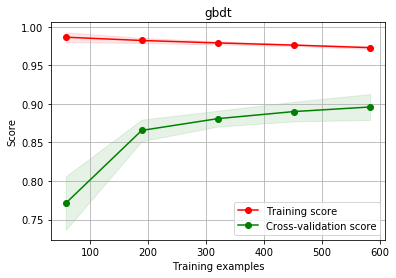

In [67]:
#gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=Nonemax_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000,\
                             silent=False, objective='reg:linear', subsample=0.7,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=0.001)
plot_learning_curve(xgb_model, 'gbdt', X_train, y_train, cv=5)
plt.show()

In [68]:
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.88027425879399812

In [31]:
0.87161084260404043

0.8716108426040404

In [70]:
X_train_df.columns

Index(['GrLivArea', 'BsmtFinSF1', 'GarageQual', 'Electrical', 'TotalBsmtSF',
       'LotShape', 'LotArea', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'HouseStyle', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterCond', 'Foundation', 'Has_Bsmt', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'HeatingQC', 'CentralAir', '2ndFlrSF', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'Functional',
       'FireplaceQu', 'Has_Garage', 'GarageType', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [69]:
y_predict = xgb_model.predict(X_test_df.values)

In [71]:
y_predict_df = pd.DataFrame(y_predict, index=X_test_df.index)
y_predict_df = y_predict_df.rename(columns={0:'SalePrice'})

In [72]:
y_predict_df['SalePrice'] = np.power(np.e, y_predict_df['SalePrice']) - 1
y_predict_df.to_csv('../data/online/predict.csv', header = True, index=True)

In [73]:
y_predict_df['SalePrice']

Id
1461    125250.703125
1462    163291.500000
1463    192669.734375
1464    199349.796875
1465    177773.421875
1466    181320.171875
1467    184213.515625
1468    170421.406250
1469    185450.921875
1470    136201.515625
1471    191798.015625
1472     98986.992188
1473    103825.710938
1474    149484.234375
1475    111668.429688
1476    377709.843750
1477    240436.968750
1478    288629.687500
1479    326847.750000
1480    491005.843750
1481    320462.656250
1482    187432.187500
1483    174440.234375
1484    158995.953125
1485    164678.515625
1486    194692.468750
1487    329476.000000
1488    238497.390625
1489    185286.343750
1490    250487.468750
            ...      
2890     80859.867188
2891    131440.421875
2892     48335.937500
2893     76147.671875
2894     80085.281250
2895    334044.937500
2896    282150.406250
2897    200714.921875
2898    162950.812500
2899    206018.468750
2900    157317.671875
2901    188989.828125
2902    195816.250000
2903    378579.687500
2904   